# Imports

In [ ]:
# pip install scipy

In [670]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy import integrate

# Model Parameters

In [831]:
# problem parameters
N = 100             # stages
iterationNumb = 100 # iterations for MCS
r_p = 1.01          # discount rate
r_m = 0.99
C = 600             # Business ticket price
pp = 1              # probability free spot at stage k=0
# Gaussian parameters
mu = 200            # mean price in dollars
sigma = 50          # std deviation of price
q = 0.8             # probability to controll discount rate

# Exact Method

we start by generating $N$ normaly ditributed variables $\omega_k\sim\mathcal{N}\left(\mu_k,\sigma_k\right)$ with $\mu_k=\mu\cdot r^k$ and $\sigma_k = \frac{\sigma}{k}$.

In [832]:
def normalOmega(loc, scale, n, seed=1234):
    # We fix the seed to reproduce same results
    np.random.seed(seed)
    omega = np.array([])
    r_pp = np.random.binomial(1, q, n)
    
    # Gaussian parameters
    # mu_arr = np.array([loc * (((r_p-r_m)*r_pp[k]+r_m)**(k+1)) for k in range(n)])
    mm = [loc]* n
    for k in range(1,n):
        mm[k] = mm[k-1] * (((r_p-r_m)*r_pp[k]+r_m))
    mu_arr = np.array([mm[k] for k in range(n)])
    sigma_arr = np.array([scale/np.sqrt(k+1) for k in range(n)])
    
    np.random.seed(seed)
    omega = np.append(omega, [np.round_(np.random.normal(mu_arr[k], sigma_arr[k], 1), 2) for k in range(n)])
    
    return omega, mu_arr, sigma_arr

In [833]:
omega, mu_arr, sigma_arr = normalOmega(mu, sigma, N)
omega

array([223.57, 159.89, 245.38, 198.24, 192.01, 228.31, 228.55, 198.93,
       208.34, 170.54, 225.4 , 224.46, 225.46, 187.35, 212.19, 218.7 ,
       225.77, 226.47, 240.45, 205.75, 223.06, 220.53, 231.82, 237.75,
       242.96, 227.48, 240.9 , 219.57, 237.41, 251.17, 235.51, 244.46,
       248.18, 250.42, 251.17, 245.29, 249.79, 243.66, 255.48, 265.16,
       249.31, 246.84, 253.99, 240.61, 260.67, 254.79, 263.02, 266.79,
       274.72, 273.54, 280.63, 267.46, 270.63, 282.38, 282.2 , 282.07,
       288.21, 282.78, 283.86, 292.96, 279.57, 288.22, 293.5 , 293.17,
       303.83, 285.62, 315.8 , 293.43, 304.64, 310.61, 304.8 , 315.28,
       319.8 , 321.88, 316.68, 330.32, 323.29, 318.69, 332.02, 331.97,
       337.65, 318.74, 342.29, 339.22, 342.66, 342.87, 352.75, 350.4 ,
       350.04, 359.43, 356.03, 357.08, 357.43, 356.12, 366.91, 365.93,
       368.26, 368.98, 364.6 , 371.12])

We define our probybility function, the probability of a free spot in the plane (economy section). We define $p(k)$ such that $p(k)>p(k+1)$.

In [834]:
def p(k):
    return pp/(k+1)

We compute our $\alpha_k$ to help compute the cost-to-go funtion as,
\begin{equation}
    \alpha_k = \left\{
            \begin{array}{ll}
                C & \text{if } k = N\\
                \mathbb{E}\left[p(N-1)\min\left\{\omega_{N-1},C\right\} + (1-p(N-1))C\right] & \text{if } k = N-1\\
                p(k)\mathbb{E}_{\omega_k}\left[\min\left\{\omega_k,\alpha_{k+1}\right\}\right] + (1-p(k))\mathbb{E}_{\omega_k}\left[\min\left\{C,\alpha_{k+1}\right\}\right] & \text{otherwise}.
            \end{array}
        \right.
\end{equation}

In [835]:
alpha = np.zeros((N,), dtype=np.float64)
alpha[N-1] = C

for k in range(N-2,-1,-1):
    integrand = lambda x:  min(x, alpha[k+1]) * np.exp(- 1/2 * ((x - mu_arr[k])/sigma_arr[k])**2) / (sigma_arr[k]*np.sqrt(2*np.pi))
    expected_min = integrate.quad(integrand, -np.Inf, np.Inf)[0]
    
    alpha[k] = np.round_(p(k) * expected_min + (1-p(k)) * min(C, alpha[k+1]), 2)

In [836]:
alpha

array([ 36.38,  36.39,  36.39,  36.39,  36.39,  36.39,  36.39,  42.46,
        48.52,  54.59,  60.65,  66.72,  72.78,  78.84,  84.9 ,  90.96,
        97.02, 103.08, 109.14, 115.2 , 121.26, 127.32, 133.38, 139.44,
       145.5 , 151.56, 157.62, 163.68, 169.74, 175.8 , 181.86, 187.92,
       193.98, 200.04, 206.1 , 212.16, 218.22, 224.28, 230.34, 236.4 ,
       242.46, 248.52, 254.58, 260.64, 266.7 , 272.76, 278.82, 284.88,
       290.94, 297.  , 303.06, 309.12, 315.18, 321.24, 327.3 , 333.36,
       339.42, 345.48, 351.54, 357.6 , 363.66, 369.72, 375.78, 381.84,
       387.9 , 393.96, 400.02, 406.08, 412.14, 418.2 , 424.26, 430.32,
       436.38, 442.44, 448.5 , 454.56, 460.62, 466.68, 472.74, 478.8 ,
       484.86, 490.92, 496.98, 503.04, 509.1 , 515.16, 521.22, 527.28,
       533.34, 539.4 , 545.46, 551.52, 557.58, 563.64, 569.7 , 575.76,
       581.82, 587.88, 593.94, 600.  ])

#### Dynamic programming solution

We use backward chaining to compute the cost-to-go starting from $k=N$,
\begin{equation}
    \hat{J}_{k}(\tilde{x}_k) = p(k-1)\min\left\{\omega_{k-1},\alpha_k\right\} + (1-p(k-1))\min\left\{C,\alpha_k\right\}.
\end{equation}

In [837]:
iterationNumb = 1000
lapTime = np.zeros((iterationNumb,), dtype=np.float64)
exitLap = np.zeros((iterationNumb,), dtype=np.int64)

for i in range(iterationNumb):
    
    # generate random variables omega
    omega, mu_arr, sigma_arr = normalOmega(mu, sigma, N, i**2) #i**2

    J = np.zeros((N,), dtype=np.float64)
    u = np.zeros((N,), dtype=np.int64)

    # J[-1] = omega[-1]
    # u[-1] = 1

    # exit index
    exit = N

    for k in reversed(range(1,N+1)):
        J[k-1] = p(k-1) * min(omega[k-1], alpha[k-1]) + (1-p(k-1)) * min(C, alpha[k-1])
        u[k-1] = (omega[k-1] <= alpha[k-1] or C <= alpha[k-1])

        # memorize exiting index
        if u[k-1] == 1:
            exit = k-1

    # setting u to zeo after first u = 1
    if exit < N:
        u[exit+1:] = 0
        
    lapTime[i] = np.dot(J, u)
    exitLap[i] = 1 + np.argmax(u)

In [838]:
print(f'Average time: {np.mean(lapTime)}')

Average time: 256.70314202423884


In [839]:
# exitLap
unique, counts = np.unique(exitLap, return_counts=True)
counts
unique

array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55])

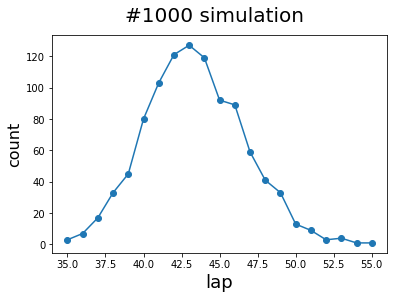

In [841]:
fig = plt.figure()
plt.plot(unique, counts, '-o')

fig.suptitle('#1000 simulation', fontsize=20)
plt.xlabel('lap', fontsize=18)
plt.ylabel('count', fontsize=16)
fig.savefig('plt1.jpg')

plt.show()

# Approximate Method

##### Q = 10            # number of samples
size = 100

In [ ]:
def linearArchitecture(N, Q, loc, scale, r, l=2):
    k = N-1
    r_hat = np.zeros((N+1,3))
    r_hat[-1] = [1, 1, 1]
    while k >= 0:
        s = 1
        beta_k = np.zeros(Q)
        phi_k = np.zeros((Q, size, l+1))
        x_k_s = np.zeros(Q)
        phi_ks = np.zeros((Q, l+1))
        while s <= Q:
            omega = np.round_(np.random.normal(loc * (r**(k+1)), scale/(k+1), size), 2)
            p_k = p/(k+1)
            x_k_s[s-1] = np.random.normal(loc * (r**(k+1)), scale/(k+1))
            phi_ks[s-1] = np.array([x_k_s[s-1] ** i for i in range(l+1)])
            g_k_s = p_k*x_k_s[s-1] + (1-p_k)*C
            phi_k[s-1] = np.array([(omega ** i).tolist() for i in range(l+1)]).T
            beta_k_s = np.mean(np.minimum(g_k_s, np.dot(phi_k[s-1], r_hat[k+1])), axis=0)
            beta_k[s-1] = beta_k_s
            s = s+1
        r_k = 1/(np.sum(np.dot(phi_ks.T, phi_ks))) * np.sum(np.dot(beta_k, phi_ks))
        r_hat[k] = r_k
        k = k-1
    return r_hat

In [ ]:
linearArchitecture(N, Q, mu, sigma, r, l=2)

In [ ]:
print("done")

In [ ]:
y = np.array([[i**2, 1] for i in range(5)], dtype=int)
y

In [ ]:
x = np.array([[2, 2, 2], [1, 1, 1]])
y = np.array([1, 2])
np.dot(x,y,axis=0)

In [ ]:
import jax.numpy as jnp

In [ ]:
pip install scipy

In [ ]:
integrand = lambda x:  min(x, a) * np.exp(- 1/2 * ((x - mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))
integrate.quad(integrand, -np.Inf, np.Inf)

In [ ]:
a = 1

In [ ]:
np.Inf

In [ ]:
np.pi

In [344]:
np.random.seed(1234)
np.random.binomial(1, 0.6, 10)

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0])